# Building a stacked autoencoders with classifier head

why use sae with classifier head?
Limited labeled data: you can exploit unlabeled data to learn useful features.
Transfer learning: pretrain SAE on one dataset, fine-tune on a smaller labeled dataset.

If you have enough labelled data, even a small CNN from scratch usually hits >90% accuracy

In [1]:
import torch
from torch import nn, optim, functional, utils

from torch.nn import BCELoss, init
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
import torchvision.transforms as transforms


import time, os

Below function get_mnist_loader creates training and testing data loaders for the FashionMNIST dataset.
It first defines a transformation to convert images into PyTorch tensors and normalize their values.
Then, it downloads the FashionMNIST training and test datasets with this transform applied.
To make results reproducible, it sets a random seed and randomly selects a fixed number of samples (num_train_samples and num_test_samples).
Subset samplers are created to only use these selected samples.
Finally, PyTorch DataLoader objects are built for both training and testing, with the specified batch_size, and returned for later use.

In [4]:


# We automate the dataloading process for future use
def get_mnist_loader(batch_size=32, num_train_samples = 50000, num_test_samples = 1000):
    """

    :return: train_loader, test_loader
    """

    transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.0,), (1.0,))  # Normalize the tensor with mean 0 and standard deviation 1
    ])
    train_dataset = datasets.FashionMNIST(root='data',
                          train=True,
                          transform=transform,
                          download=True)
    test_dataset = datasets.FashionMNIST(root='data',
                         train=False,
                         transform=transform,
                         download=True)

    # Fix the random seed to select the same subset of samples
    torch.manual_seed(42)
    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)
    return train_loader, test_loader

This class defines a single autoencoder layer used in a stacked autoencoder.
It takes an input_dim and hidden_dim to build a fully connected encoder and decoder, both using Sigmoid activation.
The SelfTraining flag controls whether the layer behaves like a full autoencoder (encode → decode → reconstruct input) for unsupervised pretraining, or just as an encoder (encode only) when stacked into a larger network.
The forward method returns either the reconstruction (if self-training) or the encoded representation (if used as part of a stack).
There are helper methods lock_grad() and acquire_grad() to freeze or unfreeze parameters during layer-wise pretraining.
The class also provides property accessors (input_dim, output_dim, is_training_layer) to check or update layer settings.

In [6]:
class AutoEncoderLayer(nn.Module):
    """
    fully-connected linear layers for stacked autoencoders.
    This module can automatically be trained when training each layer is enabled
    Yes, this is much like the simplest auto-encoder
    """
    def __init__(self, input_dim=None, hidden_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()
        # If input_dim is None or hidden_dim is None:
        # raise ValueError
        self.in_features = input_dim
        self.out_features = hidden_dim
        # Whether to conduct layer-by-layer pre-training, or train the entire network
        self.is_training_self = SelfTraining
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.Sigmoid()  # use Sigmoid activation function
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True),
            nn.Sigmoid()
        )
        #self._initialize_weights()

    def forward(self, x):
        out = self.encoder(x)
        if self.is_training_self:
            return self.decoder(out) # If the layer is not in training mode, it will just encode the data and pass it through
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other

This class builds a classifier by stacking the encoder parts of pretrained autoencoder layers.
It takes a list of autoencoders and extracts only their encoder networks, chaining them together in encoder_layers.
After the final encoder, it adds a fully connected classification layer that maps the last hidden representation to num_classes output units.
In the forward pass, the input data is passed through all encoder layers to produce a compact representation, and then through the classification layer to produce raw class scores (logits).
No softmax is applied because PyTorch’s CrossEntropyLoss expects logits directly.

In [7]:
class StackedAutoEncoderClassifier(nn.Module):
    """
    Stack the trained autoencoder layers and add a classification layer at the end
    """

    def __init__(self, autoencoder_list=None, num_classes=10):
        super(StackedAutoEncoderClassifier, self).__init__()
        # Use only the encoder parts of the autoencoders
        self.encoder_layers = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.num_classes = num_classes

        # Classification layer
        self.classification_layer = nn.Linear(autoencoder_list[-1].out_features, num_classes)
        #Note that we don't implement a softmax activation, as this is already taken care of in the CrossEntropyLoss class
        #(see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

    def forward(self, x):
        encoded_representation = x
        for layer in self.encoder_layers:
            encoded_representation = layer(encoded_representation)

        # Classification layer
        output = self.classification_layer(encoded_representation)
        return output


This function trains one autoencoder layer at a time.
It freezes all previously trained layers so only the current layer updates.
Each batch of images is flattened, passed through the frozen layers, and then reconstructed by the current layer.
The reconstruction loss (MSE) is computed between the layer’s output and its input, and the weights of the current layer are updated with SGD.
After each epoch, the function prints the training loss.

In [8]:
def train_layer(layers_list=None, train_loader= None, test_loader= None, layer=None, epochs=None, validate=True):
    """
    Greedy layer-wise training: when training the i-th layer, freeze the i-1 layer
    :param layers_list: all autoencoder layers to train
    :param layer: which autoencoder layer to train
    :return:
    """
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    optimizer = optim.SGD(layers_list[layer].parameters(), lr=0.1)
    criterion = torch.nn.MSELoss()

    # Train
    for epoch_index in range(epochs):
        sum_loss = 0.

        # Freeze the parameters of all layers before the current layer
        # Layer 0 has no previous layer
        if layer != 0:
            for index in range(layer):
                # In addition to freezing parameters
                # the output return method of the frozen layer must also be set.
                layers_list[index].lock_grad()
                layers_list[index].is_training_layer = False

        for batch_index, (train_data, _) in enumerate(train_loader):
            # Generate input data
            if torch.cuda.is_available():
                train_data = train_data.cuda()  # Put data onto GPU
            out = train_data.view(train_data.size(0), -1)

            # Perform forward calculation on the frozen layers before (layer-1)-th layer
            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)

            # Train the layer-th layer
            pred = layers_list[layer](out)

            optimizer.zero_grad()
            loss = criterion(pred, out)
            sum_loss += loss
            loss.backward()
            optimizer.step()
            #if (batch_index + 1) % 20 == 0:
        print("Train Layer: {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(
            layer, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))

        if validate:
            pass

This function trains the stacked autoencoder as a classifier.
If fine_tuning=True, it unfreezes all parameters; otherwise it only trains the classification head.
It uses SGD and cross-entropy loss, sets the model to train mode, and iterates over training batches: flatten images, run the model, compute loss, backpropagate, and update weights.
After training epochs finish, it switches to eval mode and runs through the test loader without gradients to get predictions.
It then computes and prints overall test accuracy, and returns the model and that accuracy.

In [9]:
def train_classifier(model=None, train_loader=None, test_loader=None, epochs=20, fine_tuning = False):

    print(">> start training whole model")
    if torch.cuda.is_available():
        model.cuda()

    # unfreeze the parameters frozen in pre-training if needed
    if fine_tuning:
      for param in model.parameters():
          param.requires_grad = True
      training_phase = 'Fine-Tuning'
    else:
      training_phase = 'Classifier'

    optimizer = optim.SGD(model.parameters(), lr=1)
    criterion = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    # train
    for epoch_index in range(epochs):
        sum_loss = 0.
        for batch_index, (train_data, train_labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                train_data, train_labels = train_data.cuda(), train_labels.cuda()
            x = train_data.view(train_data.size(0), -1)

            predicted_labels = model(x)

            optimizer.zero_grad()
            loss = criterion(predicted_labels, train_labels)
            sum_loss += loss
            loss.backward()
            optimizer.step()

        print("Train {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(training_phase, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))

    print("<< end training whole model")
    print("Calculating accuracy on the whole test set")

    # Set model to evaluation mode
    model.eval()

    # Calculate accuracy on the test set
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch_data in test_loader:
            images, labels = batch_data
            images = images.view(images.size(0), -1)
            if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # Get the highest value for each point to get the label
            _, predicted_labels = torch.max(outputs.data, 1)
            # Count number of correct predictions in the batch
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)


    # Compute average test loss
    accuracy = total_correct / total_samples
    print('Accuracy on the test set: {:.6f}'.format(accuracy))
    return model, accuracy


In [10]:
# You can change the hyper-parameters here
# Be sure to try out different combinations of epochs for the pretraining and fine-tuning
num_layer_wise_epochs = 10
num_classifier_epochs = 10
num_finetuning_epochs = 20
batch_size = 128

In [ ]:
# Get the dataloaders of the training dataset
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

input_dim = 784
# Define the autoencoder layers
# Try different values for the dimensions of the hidden layers and the number of layers
encoder_1 = AutoEncoderLayer(input_dim = input_dim, hidden_dim = 256, SelfTraining=True)
encoder_2 = AutoEncoderLayer(input_dim = 256, hidden_dim = 64, SelfTraining=True)

encoders_list = [encoder_1, encoder_2]
num_layers = len(encoders_list)


# Pre-train each layer
for level in range(num_layers):
   train_layer(layers_list=encoders_list, train_loader=train_loader, test_loader=test_loader, layer=level, epochs=num_layer_wise_epochs, validate=True)

# Build the stacked autoencoder
SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoders_list, num_classes = 10)
# Print the model
print(SAE_model)

# First train the classification layer
train_classifier(model=SAE_model, train_loader=train_loader, test_loader=test_loader, epochs=num_classifier_epochs, fine_tuning = False)

# Train the whole model and perform fine-tuning
train_classifier(model=SAE_model, train_loader=train_loader, test_loader=test_loader, epochs=num_finetuning_epochs, fine_tuning = True)


# Save the model (refer: https://pytorch.org/docs/master/notes/serialization.html)


Train Layer: 0, Epoch: 1/10, Iter: 391/391, Loss: 0.1235
Train Layer: 0, Epoch: 2/10, Iter: 391/391, Loss: 0.1060
Train Layer: 0, Epoch: 3/10, Iter: 391/391, Loss: 0.0949
Train Layer: 0, Epoch: 4/10, Iter: 391/391, Loss: 0.0880
Train Layer: 0, Epoch: 5/10, Iter: 391/391, Loss: 0.0917
Train Layer: 0, Epoch: 6/10, Iter: 391/391, Loss: 0.0865
Train Layer: 0, Epoch: 7/10, Iter: 391/391, Loss: 0.0783
Train Layer: 0, Epoch: 8/10, Iter: 391/391, Loss: 0.0897
Train Layer: 0, Epoch: 9/10, Iter: 391/391, Loss: 0.0881
Train Layer: 0, Epoch: 10/10, Iter: 391/391, Loss: 0.0830
Train Layer: 1, Epoch: 1/10, Iter: 391/391, Loss: 0.0207
Train Layer: 1, Epoch: 2/10, Iter: 391/391, Loss: 0.0113
Train Layer: 1, Epoch: 3/10, Iter: 391/391, Loss: 0.0075
Train Layer: 1, Epoch: 4/10, Iter: 391/391, Loss: 0.0056
Train Layer: 1, Epoch: 5/10, Iter: 391/391, Loss: 0.0058
Train Layer: 1, Epoch: 6/10, Iter: 391/391, Loss: 0.0056
Train Layer: 1, Epoch: 7/10, Iter: 391/391, Loss: 0.0057
Train Layer: 1, Epoch: 8/10, I

"import os\nif not os.path.exists('/mnt/d/OneDrive - KU Leuven/Master of AI/ANN/session2/models'):\n   os.makedirs('/mnt/d/OneDrive - KU Leuven/Master of AI/ANN/session2/models')\ntorch.save(SAE_model, '/mnt/d/OneDrive - KU Leuven/Master of AI/ANN/session2/models/sae_model.pt')"

Classification report:
               precision    recall  f1-score   support

 T-shirt/top     0.8421    0.8312    0.8366        77
     Trouser     1.0000    0.9685    0.9840       127
    Pullover     0.7732    0.8427    0.8065        89
       Dress     0.7692    0.9091    0.8333        99
        Coat     0.8081    0.8333    0.8205        96
      Sandal     0.9810    0.9810    0.9810       105
       Shirt     0.7846    0.5484    0.6456        93
     Sneaker     0.9528    0.9712    0.9619       104
         Bag     0.9429    0.9802    0.9612       101
  Ankle boot     0.9907    0.9725    0.9815       109

    accuracy                         0.8920      1000
   macro avg     0.8845    0.8838    0.8812      1000
weighted avg     0.8927    0.8920    0.8896      1000



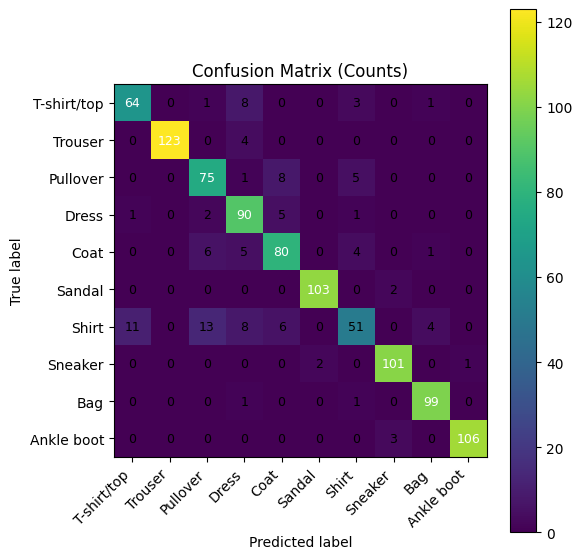

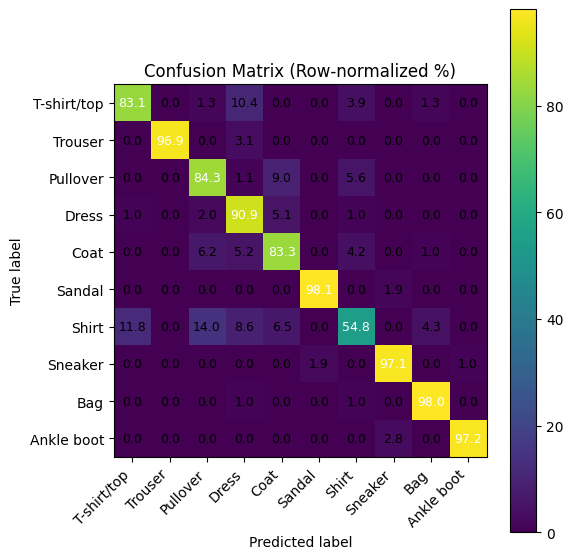

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ----- class names -----
classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAE_model.to(device)
SAE_model.eval()


all_y, all_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.view(x.size(0), -1).to(device)  # flatten 28x28 -> 784
        logits = SAE_model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_pred.append(preds)
        all_y.append(y.numpy())

y_true = np.concatenate(all_y)
y_pred = np.concatenate(all_pred)

cm_counts = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
cm_norm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)

print("Classification report:\n",
      classification_report(y_true, y_pred, target_names=classes, digits=4))


def plot_cm(cm, class_names, title="Confusion Matrix", cmap="viridis", fmt=".0f"):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # annotate cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, format(val, fmt),
                     ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=9)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


plot_cm(cm_counts, classes, title="Confusion Matrix (Counts)", fmt=".0f")


plot_cm(cm_norm * 100, classes, title="Confusion Matrix (Row-normalized %)", fmt=".1f")
